# MIMIC NLP

This project focuses on extracting medical entities from clinical notes using scispaCy and ClinicalBERT, followed by word vector analysis using pre-trained embeddings and custom Word2Vec models. The extracted entities are visualized using t-SNE to understand their relationships in a lower-dimensional space.  

**GitHub Repository**: [https://github.com/Dominick99/AI-395T](https://github.com/Dominick99/AI-395T)

## Citations  

**Johnson, A., Pollard, T., & Mark, R. (2016).** MIMIC-III Clinical Database (version 1.4). PhysioNet. [https://doi.org/10.13026/C2XW26](https://doi.org/10.13026/C2XW26).  

**Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016).** MIMIC-III, a freely accessible critical care database. *Scientific Data, 3*, 160035.  

**Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000).** PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. *Circulation [Online], 101 (23)*, pp. e215–e220.  

### Additional Resources:  
- **ClinicalBERT:** [https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT)  
- **spaCy Model:** [https://spacy.io/models/en#en_core_web_lg](https://spacy.io/models/en#en_core_web_lg)  
- **scispaCy Documentation:** [https://allenai.github.io/scispacy/](https://allenai.github.io/scispacy/)  
- **Pre-trained GloVe Embeddings:** [https://huggingface.co/fse/glove-wiki-gigaword-100](https://huggingface.co/fse/glove-wiki-gigaword-100)  


# Create Subset of NOTEEVENTS

We begin by examining the `DIAGNOSES_ICD` table and identifying rows containing the ICD-9 code `99591` (sepsis). From these rows, we extract the corresponding `SUBJECT_ID` and `HADM_ID` pairs. Next, we filter the `NOTEEVENTS` table, retaining only rows where the `SUBJECT_ID` and `HADM_ID` match those in our extracted set. This results in a subset of `NOTEEVENTS`, where each row represents a patient admission associated with a sepsis diagnosis.

In [20]:
import pandas as pd

# Load only necessary columns
diagnoses_icd_df = pd.read_csv(
    "DIAGNOSES_ICD.csv.gz",
    compression="gzip",
    usecols=["SUBJECT_ID", "HADM_ID", "ICD9_CODE"]  # Load only relevant columns
)

noteevents_df = pd.read_csv(
    "NOTEEVENTS.csv.gz",
    compression="gzip",
    usecols=["SUBJECT_ID", "HADM_ID", "CATEGORY", "TEXT"]  # Load only relevant columns
)

# Filter diagnoses to get only SUBJECT_ID & HADM_ID pairs for sepsis (ICD9_CODE == '99591')
sepsis_hadm_pairs = diagnoses_icd_df.loc[diagnoses_icd_df['ICD9_CODE'] == '99591', ['SUBJECT_ID', 'HADM_ID']]

# Convert to set for fast lookup
sepsis_hadm_pairs_set = set([tuple(x) for x in sepsis_hadm_pairs.to_numpy()])
print(f"Filtered {len(sepsis_hadm_pairs)} unique (SUBJECT_ID, HADM_ID) pairs.")

# Filter NOTEEVENTS using BOTH SUBJECT_ID & HADM_ID
patients_df_discharge = noteevents_df[
    noteevents_df.apply(lambda row: (row['SUBJECT_ID'], row['HADM_ID']) in sepsis_hadm_pairs_set, axis=1)
]

# Save to CSV
print(f"Final dataset size: {len(patients_df_discharge)}")
patients_df_discharge.to_csv("ICD9-995_Patients_DischargeSummary_Random10_discharge.csv", index=False)

Filtered 1272 unique (SUBJECT_ID, HADM_ID) pairs.
Final dataset size: 46297


# Create Helper Functions

In [29]:
import pandas as pd
import re
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

def create_notes(path, num_rows=1000, random_state=42, lowercase=True, remove_symbols=False, remove_numbers=False):
    # Load the CSV file
    df = pd.read_csv(path)

    # Sample random rows
    df_sampled = df.sample(n=num_rows, random_state=random_state)  # Set random_state for reproducibility

    # Ensure the 'TEXT' column is treated as string
    df_sampled['TEXT'] = df_sampled['TEXT'].astype(str)

    # Convert text to lowercase if specified
    if lowercase:
        df_sampled['TEXT'] = df_sampled['TEXT'].str.lower()

    # Remove symbols if specified
    if remove_symbols:
        df_sampled['TEXT'] = df_sampled['TEXT'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

    # Remove numbers if specified
    if remove_numbers:
        df_sampled['TEXT'] = df_sampled['TEXT'].apply(lambda x: re.sub(r'\d+', '', x))

    # Extract text from sampled rows
    notes = df_sampled['TEXT'].tolist()

    # Print the number of sampled notes
    print(f"Sampled {len(notes)} discharge summaries.")

    return notes

def extract_entities(spacy_model, notes):

  # Process each note and visualize named entities
  for note in notes[:1]:  # Limit for readability
      doc = spacy_model(note)  # Convert raw text to a SpaCy Doc object
      displacy.render(doc, style="ent", jupyter=True)  # Pass the processed Doc object
      print('*' * 150)

  # Extract named entities for each note and store them in the corpus
  corpus = [[ent.text for ent in spacy_model(note).ents] for note in notes]

  return corpus

def plot_tsne_embeddings(word_embeddings: dict, words: list, n: int,
                          perplexity=30, early_exaggeration=12, n_components=2,
                          init='pca', max_iter=1000, random_state=23):
    """
    Plots a TSNE visualization of word embeddings.

    Parameters:
    - word_embeddings: dict, mapping words to their vector representations
    - words: list of words to visualize
    - n: number of words to sample from the intersection
    - perplexity: TSNE perplexity parameter
    - early_exaggeration: TSNE early exaggeration parameter
    - n_components: number of TSNE components (default: 2)
    - init: TSNE initialization method
    - n_iter: Number of iterations for optimization
    - random_state: Random seed for reproducibility
    """
    # Get words that exist in both list and embeddings
    common_words = list(set(words) & set(word_embeddings.keys()))

    if len(common_words) < n:
        raise ValueError(f"Only {len(common_words)} words found in embeddings, but {n} were requested.")

    # Select n words
    selected_words = np.random.choice(common_words, n, replace=False)

    # Extract corresponding vectors
    vectors = np.array([word_embeddings[word] for word in selected_words])

    # Apply TSNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, early_exaggeration=early_exaggeration,
                init=init, max_iter=max_iter, random_state=random_state)
    reduced_vectors = tsne.fit_transform(vectors)

    # Plot results
    plt.figure(figsize=(16, 16))
    for word, coord in zip(selected_words, reduced_vectors):
        plt.scatter(coord[0], coord[1])
        plt.annotate(word, (coord[0], coord[1]), fontsize=12, alpha=0.75)

    plt.title("t-SNE Visualization of Word Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

def plot_word_embeddings(word_embeddings, selected_words):
    """
    Projects selected word embeddings into 2D and visualizes them as vectors with clustering colors.

    Parameters:
    word_embeddings (dict): A dictionary mapping words to their vector embeddings.
    selected_words (list): A list of words to visualize.
    """
    # Filter words that exist in the given embedding dictionary
    selected_words = [word for word in selected_words if word in word_embeddings]

    if len(selected_words) < 2:
        raise ValueError("Not enough words found in the provided dictionary for visualization.")

    # Extract vectors for selected words
    vectors = np.array([word_embeddings[word] for word in selected_words])

    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # Cluster the vectors
    num_clusters = min(5, len(selected_words))  # Choose a reasonable number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced_vectors)

    # Generate distinct colors for each cluster
    palette = sns.color_palette("winter", num_clusters)

    # Plot the vectors with colors based on clusters
    plt.figure(figsize=(8, 6))
    for word, vec, label in zip(selected_words, reduced_vectors, labels):
        plt.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color=palette[label])
        plt.text(vec[0], vec[1], word, fontsize=12, ha='right', va='bottom', color=palette[label])

    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xlim(reduced_vectors[:, 0].min() - 1, reduced_vectors[:, 0].max() + 1)
    plt.ylim(reduced_vectors[:, 1].min() - 1, reduced_vectors[:, 1].max() + 1)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("2D Projection of Word Embeddings with Clustering")
    plt.show()

# Create Notes from TEXT Column

In [2]:
notes = create_notes("ICD9-995_Patients_DischargeSummary_Random10_discharge.csv", num_rows=1000)

Sampled 1000 discharge summaries.


# Extract Entities Using spaCy

We begin by downloading spaCy along with its `en_core_web_sm` model. Next, we iterate through our filtered `NOTEEVENTS` table or a smaller subset if needed for training and entity extraction. As we process each row, we extract the `TEXT` column values as strings and append them to a `notes` list. Finally, we iterate through each note, apply the `en_core_web_sm` model to extract entities, and store the results in a `corpus` list.


In [3]:
nlp = spacy.load('en_core_web_sm')

corpus = extract_entities(nlp, notes)

******************************************************************************************************************************************************


# Create Word Embeddings Using a Pre-Trained Word2Vec Model then Plot a t-SNE Graph  

We begin by downloading the `"glove-wiki-gigaword-100"` pre-trained model, which contains GloVe vectors trained on 2 billion tweets, with a vocabulary of 1.2 million uncased tokens. Each word in this model is represented by a 100-dimensional vector.  

Next, we flatten our corpus into a 1D array of entities extracted using spaCy. We then identify the intersection of words present in both our corpus and the pre-trained model’s vocabulary. Finally, we reduce the 100-dimensional word vectors to 2D using t-SNE and visualize them with a scatter plot.


In [4]:
# load pre-trained word2vec embeddings
import gensim
import gensim.downloader as api

pretrained_model= api.load("glove-wiki-gigaword-100")  # download the model and return as object ready for use

[==================================================] 100.0% 128.1/128.1MB downloaded


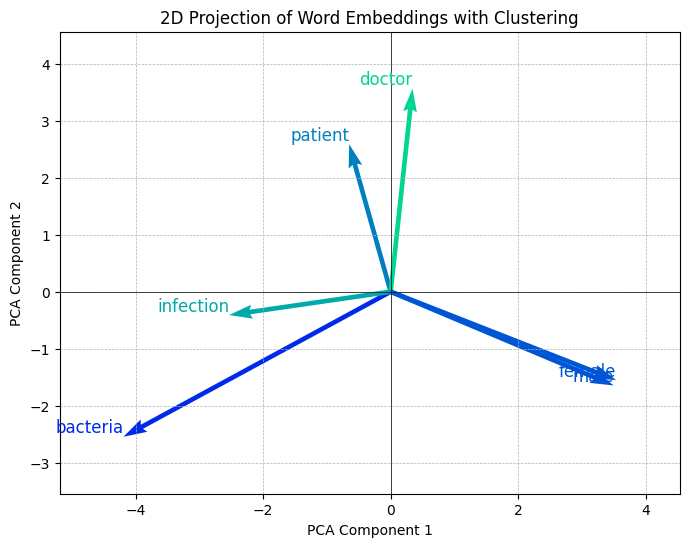

In [36]:
# Extract word embeddings as a dictionary
word_embeddings = {word: pretrained_model[word] for word in pretrained_model.key_to_index}

# Observe the vectors of similar words to confirm they are generally close
selected_words = ['patient', 'doctor', 'bacteria', 'infection', 'male', 'female']

plot_word_embeddings(word_embeddings, selected_words)

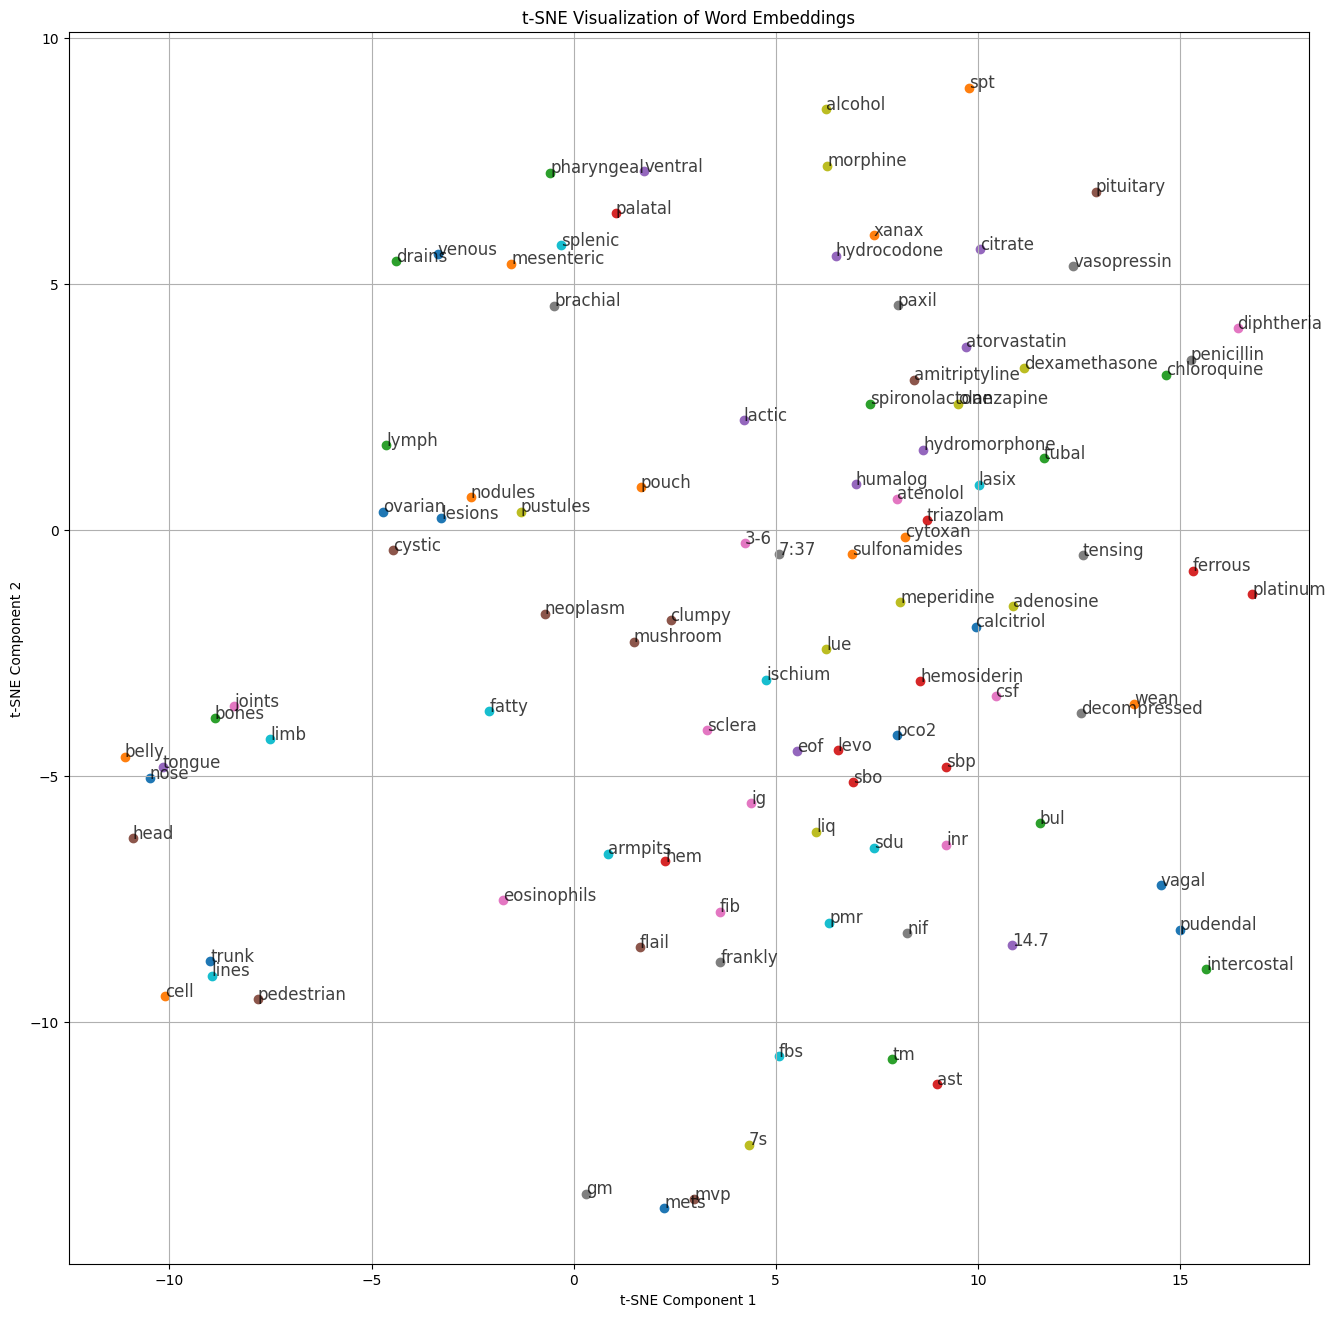

In [37]:
# Flatten corpus to get a unique list of words
words_list = list(set([word for sentence in corpus for word in sentence]))

# Call the visualization function
plot_tsne_embeddings(word_embeddings, words_list, n=100, perplexity=10, early_exaggeration=24)

# Extract Entities Using scispaCy

We begin by downloading scispaCy along with the `"en_ner_bionlp13cg_md"` model, a specialized spaCy NER model trained on the BioNLP13CG corpus. This model is particularly useful for recognizing biomedical entities, including genes, proteins, cells, chemicals, diseases, and other biological concepts.  

As before, we iterate through our filtered `NOTEEVENTS` table or a smaller subset if needed for training and entity extraction. During this process, we extract the `TEXT` column values as strings and append them to a `notes` list. To reduce entity duplication, we convert all text to lowercase and remove numbers and symbols, ensuring only word entities remain. Finally, we apply the `"en_ner_bionlp13cg_md"` model to each note, extract entities, and store them in a `corpus` list.

In [6]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bionlp13cg_md-0.5.4.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_bionlp13cg_md: filename=en_ner_bionlp13cg_md-0.5.4-py3-none-any.whl size=119814670 sha256=3218c384fb40b3f32484113fc11868749806460989a28a61638b104110409f25
  Stored in directory: /root/.cache/pip/wheels/31/ac/d1/be19808ecef0503b68100dfa881150a04957c7f9a2c4a6d0b1
Successfully built en_ner_bionlp13cg_md


In [38]:
nlp = spacy.load('en_ner_bionlp13cg_md')

corpus = extract_entities(nlp, notes)

******************************************************************************************************************************************************


# Use Pre-Trained ClinicalBERT to Get Word Vectors for the scispaCy Entities  

We begin by downloading the ClinicalBERT transformer model from Hugging Face. ClinicalBERT is a specialized BERT model pre-trained on clinical notes from MIMIC-III, making it well-suited for understanding medical terminology and context.  

Next, we extract word embeddings from ClinicalBERT and convert them into a dictionary where each word is mapped to its corresponding vector representation. These embeddings can then be used for downstream tasks such as clustering, classification, or visualization.

In [39]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Extract the embedding layer
embedding_layer = model.embeddings.word_embeddings

# Get vocabulary
vocab = tokenizer.get_vocab()

# Create dictionary mapping words to embeddings
word_embeddings = {}

for word, idx in vocab.items():
    word_tensor = torch.tensor([idx])  # Convert word index to tensor
    with torch.no_grad():
        embedding = embedding_layer(word_tensor).squeeze(0)  # Extract embedding
    word_embeddings[word] = embedding.numpy()  # Convert to NumPy array

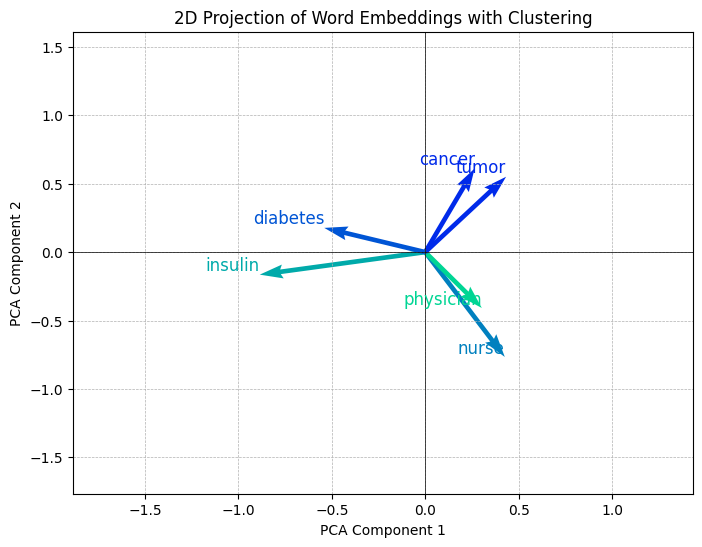

In [45]:
# Observe the vectors of similar words to confirm they are generally close
selected_words = ['nurse', 'physician', 'cancer', 'tumor', 'insulin', 'diabetes']
plot_word_embeddings(word_embeddings, selected_words)

# Create Word Embeddings Using ClinicalBERT then Plot a t-SNE Graph  

We flatten our corpus into a 1D array of entities extracted using scispaCy. We then identify the intersection of words present in both our corpus and ClinicalBERT’s vocabulary. Finally, we extract the word vectors for these entities, reduce their dimensionality to 2D using t-SNE, and visualize them with a scatter plot.


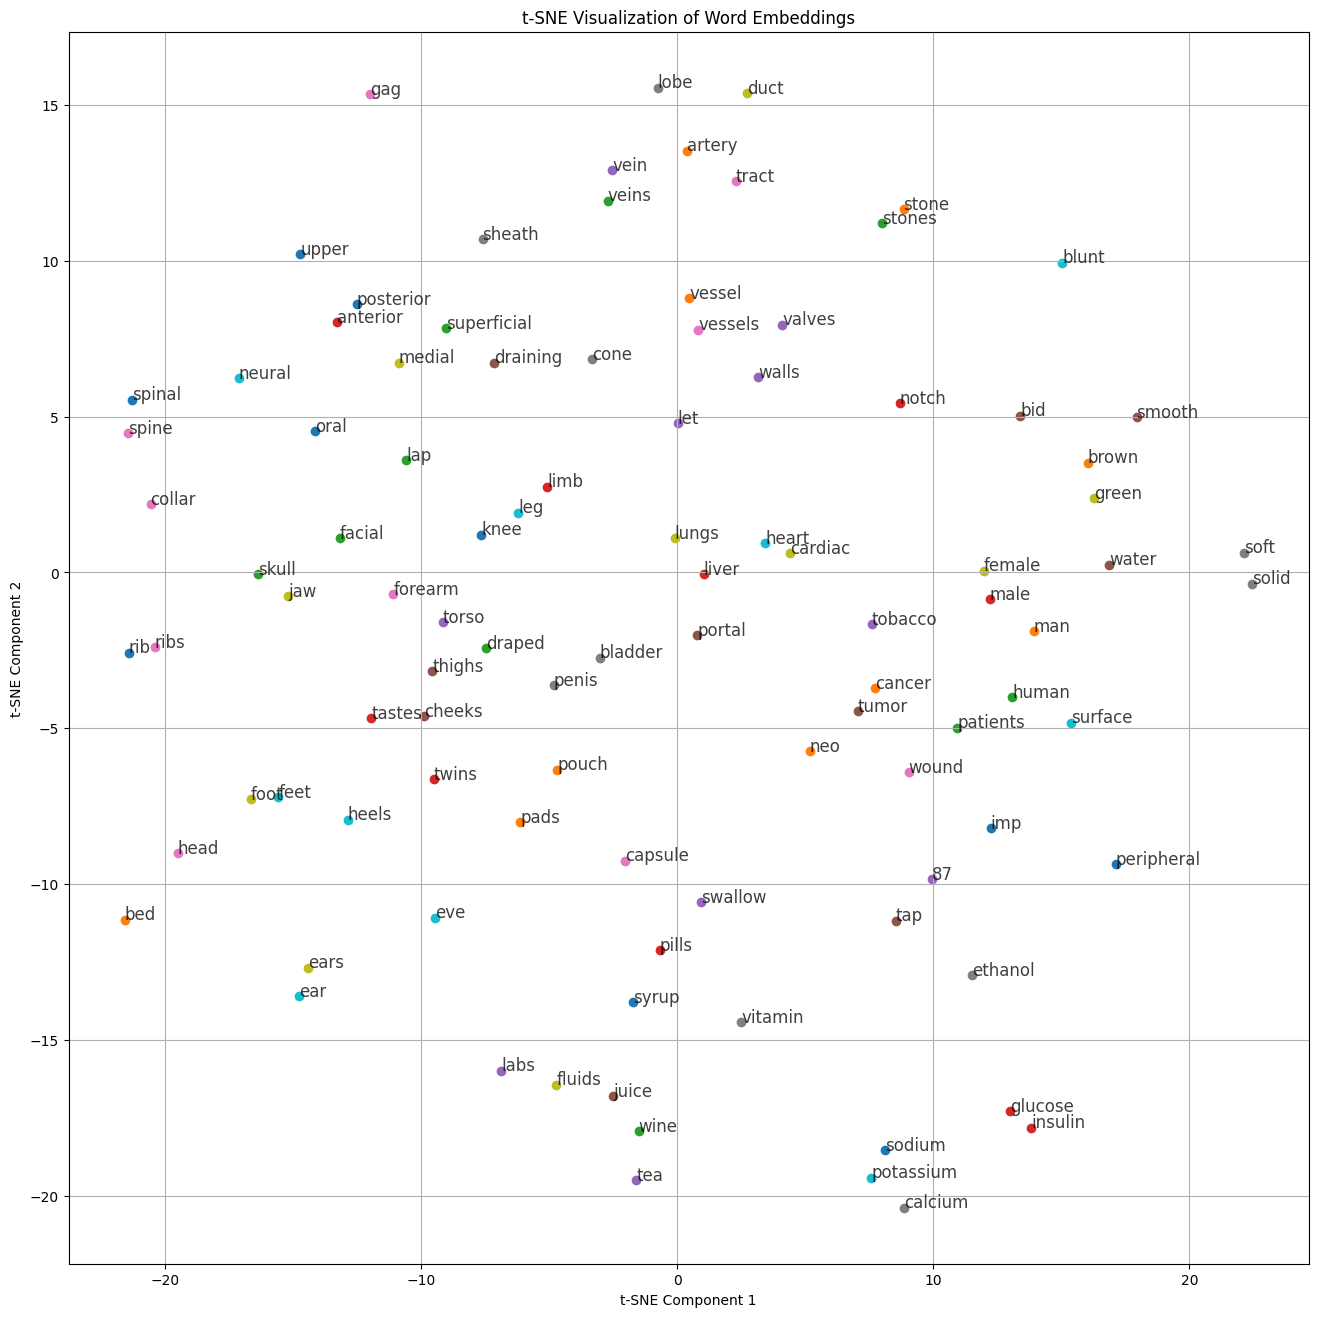

In [43]:
# Flatten corpus to get a unique list of words
words_list = list(set([word for sentence in corpus for word in sentence]))

# Call the visualization function
plot_tsne_embeddings(word_embeddings, words_list, n=100, perplexity=10, early_exaggeration=24)